# Lizard Project!

By: Katie Gosbee and Meagan Rittmanic

### Question: 
Which combination of the layers brick, balsa wood, and polyethylene would best insulate a lizard?

### Model:
We started with a stock and flow diagram, shown below. Our stocks are the temperatures of the layers and the lizard and our flows are the flow of heat between the stocks. Heat flows from the environment through the first layer of insulation, the second layer of insulation, the third layer of insulation, and finally the lizard. Each heat flow is affected by the temperature of the layers on either side of it.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

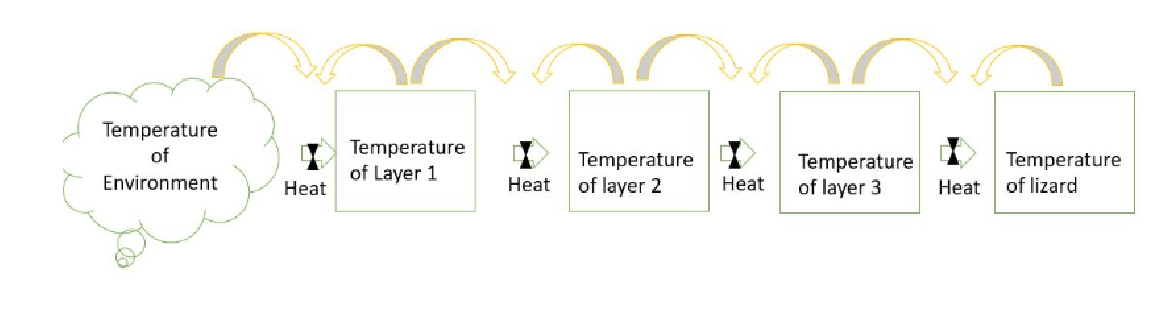

In [2]:
plt.figure(figsize=(20,10))
myImage = mpimg.imread("Flooo.PNG")
myImage = plt.imshow(myImage)
plt.axis('off')
plt.show()

After our stock and flow diagram was created, we found differential equations to guide our modeling.

First, we used the equation  $\frac{dQ}{dt}$ = $\frac{kA(T1-T2)}{d}$ where $\frac{dQ}{dt}$ is the change in thermal energy, $k$ being the thermal conductivity of the layer, $A$ being the surface area of contact between the layer and its environment, $T1$ being the temperature of the environment in degrees Celsius, and $T2$ being the temperature of the layer. 
We found this equation [here](https://www.physicsclassroom.com/class/thermalP/Lesson-1/Rates-of-Heat-Transfer), which used it for the heat transfer through a wall. This was verified by [here](https://www.youtube.com/watch?v=vUCMsvhuSFQ). In our use of this equation, we assumed that our lizard was covered in three cubes of material, so we were able to use this equation by assuming that the cube was equal to six walls surrounding the lizard.

Second, we used the differential equation $\frac{dQ}{dt}$ = $\frac{kA(Tenv-Tl)}{\frac{\delta}{2}}$ with $\frac{dQ}{dt}$ being the change in thermal energy, $Tenv$ being the temperature of the environment, $Tl$ being the temperature of the lizard, $k$ being the thermal conductivity of the lizard, $A$ being the surface area of the lizard, and $\delta$ being the average diameter of the lizard to model the heat transfer from the innermost layer to the lizard. We got this equation from [here](https://www.researchgate.net/publication/228075024_A_body_temperature_model_for_lizard_as_estimated_from_the_thermal_environment) , a study that modeled the thermal properties of the lizad Agama Agama. We assumed the surface area of the lizard was equal to the innermost surface area of our cube in our model.

Notice, we did not decide to model a system including air. We understand that in real life, if we were layering the lizard in cubes, air would be present between the lizard and innermost layer. The main purpose this air layer would serve would be just to slow down the heat transfer from the outside to the lizard, however, the lizard's temperature will still change because it's an ectotherm and it's temperature is controlled by its environment.

When modeling, we started by making a system object with all our variables for the different materials and the lizard.

In [3]:
def make_system(Tenv, K1, C1, D1, K2, C2, D2, K3, C3, D3, depth, delta, dt, side_length, ML, CL):
    """Make a system object for the Lizard model.
    returns: the new System object
    Tenv = temperature of the environment
    K1 = thermal conductivity of the first layer
    C1 = specific heat capacity of the first layer
    D1 = density of the first layer
    K2 = thermal conductivity of the second layer
    C2 = specific heat capacity of the second layer
    D2 = density of the second layer
    K3 = thermal conductivity of the third layer
    C3 = specific heat capacity of the third layer
    D3 = density of the third layer
    depth = depth of the material
    delta = average diameter of the lizard
    dt = time step used in our model
    side_length = side length of one side of the outermost cube
    ML = mass of the lizard
    CL = specific heat capacity of the lizard"""
    
    init = State(Lay1=26.7, Lay2=26.7, Lay3=26.7, L= 26.7)  
    
    t0 = 0
    t_end = 7*24*60*60*(1/dt) #in seconds
    dt = dt

    return System(init=init, t0=t0, t_end=t_end, Tenv=Tenv, K1=K1, K2=K2, K3=K3,
                  depth=depth, delta=delta, dt=dt, side_length=side_length, C1=C1, 
                  C2=C2, C3=C3, CL=CL, D1 = D1, D2=D2, D3=D3, ML=ML)

Other than creating the system, the function defined above also creates a State called init, which stores the temperature of each layer, including the lizard, which is denoted by "L". Their units are degrees Celsius and their starting temperature is the temperature for an ideal environment for a lizard. 

We decided to run this simulation for a week, indicated by the t_end value of $7*24*60*60$.

In [4]:
def update_func(state, t, system):
    """Updates the model. 
    state = temperatures of each layer (and lizard)
    t = time
    system = all the factors that affect heat transfer 
    returns: State () containing the updated variables    
    """
    unpack(system)
    lay1, lay2, lay3, l = state
   
   
    d1dt = K1*(side_length**3)*(Tenv-lay1)/depth      
    d2dt = K2*((side_length-.0127)**3)*(lay1-lay2)/depth
    d3dt = K3*((side_length-.0254)**3)*(lay2-lay3)/depth
    dLdt = ((side_length-.0381)**3)*0.5*(lay3-l)/(delta/2)
    #The above four diff EQs represent the rate of heat changing 
    #between the outer layer to the inner layer(lizard)
    
    lay1 += (d1dt/(C1*(D1*(side_length**3-(side_length-0.0127)**3))))*dt 
    lay2 += (d2dt/(C2*(D2*((side_length-.0127)**3-(side_length-0.0254)**3))))*dt
    lay3 += (d3dt/(C3*(D3*((side_length-.0254)**3-(side_length-0.381)**3))))*dt
    l += (dLdt/(CL*ML))*dt
    #these update the temps of each layer
    
    return State(Lay1=lay1, Lay2=lay2, Lay3=lay3, L=l)

Our run_simulation function puts each layer through the update_func and then returns just the lizard's temperature.

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.     
    system: System object
    update_func: function that updates state    
    returns: the column in TimeFrame that denotes the lizard's temperature
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    return frame.L

We ran the simulation for each of the six possible combinations of the layers brick, balsa wood, and polyethylene. 
We found the thermal condictivities (k-values) of each of these substances [here](https://www.engineeringtoolbox.com/thermal-conductivity-d_429.html), their densities [here](https://www.engineeringtoolbox.com/bricks-density-d_1777.html) and [here](https://www.engineeringtoolbox.com/density-solids-d_1265.html), and their specific heat capacities at [here](https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html). 

We found the  mass of the adult agama agama lizard to be 3.5g, or 0.0035kg. We chose this lizard because it was the same lizard used in the study of the thermal properties of lizards. We made our $dt$ value 100 seconds, meaning the update function was only called once every 100 seconds for the week that it was called. We assumed our delta value, the diameter of the lizard, to be .0762, or about 3 inches in diameter.  We didn't have data to support this parameter, but 3 inches seemed like a reasonable diameter of a medium-sized lizard. Additionally, this value doesn't matter in this simulation because we were only looking at the different in coolng properties. If we changed the order of the layers, and the $delta$ value stayed constant through every run. We also assumed the surface of the lizard was the innermost surface area of the cube, but isn't accurate but doesn't affect the simulation because we keep it consistent from run to run.

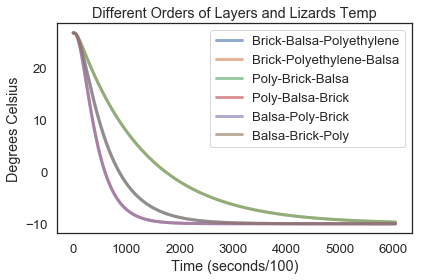

In [6]:
"""Each pair of three lines creates the system, runs the simulation with that particular system, and then plots the results
   Each system has a permutation of the three layers"""


system = make_system(-10, 1.31, 840, 1900, .048, 1500, 160, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Brick-Balsa-Polyethylene')

system = make_system(-10, 1.31, 840, 1900, 0.33, 1250, 561, .048, 1500, 160, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Brick-Polyethylene-Balsa')

system = make_system(-10, 0.33, 1250, 561, 1.31, 840, 1900, .048, 1500, 160, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Poly-Brick-Balsa')

system = make_system(-10, 0.33, 1250, 561, .048, 1500, 160, 1.31, 840, 1900, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Poly-Balsa-Brick')

system = make_system(-10, .048, 1500, 160, 0.33, 1250, 561, 1.31, 840, 1900, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Poly-Brick')

system = make_system(-10, .048, 1500, 160, 1.31, 840, 1900, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Brick-Poly')

decorate(xlabel='Time (seconds/100)',
         ylabel='Degrees Celsius',
         title = 'Different Orders of Layers and Lizards Temp')

After running all the permutations, we were surprised that our simulation seemed to suggest that when the innermost material was the same, the order of the middle and outer materials didn't matter. For instance, the cooling of the brick-polyethylene-balsa and the polyethylene-brick-balsa layers followed exactly the same line. Because of these results, we decided to run through the permutations again, this time with a material that was more different from the others than brick had been. Agate had a thermal conductity of 10.9W/m(degrees Celsius), much further from polyethylene's thermal conductivity of 0.33W/m(degrees Celsius) than brick had been, having a thermal conductivity of 1.33W/m(degrees Celsius). We expected this to produce more obvious different rates of cooling, if they existed.
Additionally, in order to distinguish between lines if they were the same, we graphed one out of every two permutations with the same innermost layer in astrixes.

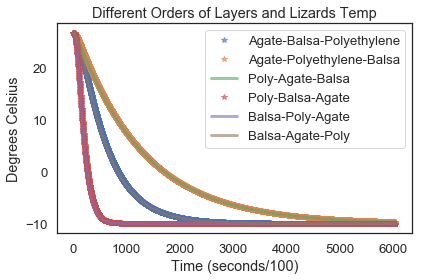

In [7]:
system = make_system(-10, 10.9, 800, 2500, .048, 1500, 160, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, '*', label = 'Agate-Balsa-Polyethylene')

system = make_system(-10, 10.9, 800, 2500, 0.33, 1250, 561, .048, 1500, 160, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, '*', label = 'Agate-Polyethylene-Balsa')

system = make_system(-10, 0.33, 1250, 561, 10.9, 800, 2500, .048, 1500, 160, .0127, .0762, 100, .2032, 0.0035, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Poly-Agate-Balsa')

system = make_system(-10, 0.33, 1250, 561, .048, 1500, 160, 10.9, 800, 2500, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, '*', label = 'Poly-Balsa-Agate')

system = make_system(-10, .048, 1500, 160, 0.33, 1250, 561, 10.9, 800, 2500, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Poly-Agate')

system = make_system(-10, .048, 1500, 160, 10.9, 800, 2500, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.0035, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Agate-Poly')

decorate(xlabel='Time (seconds/100)',
         ylabel='Degrees Celsius',
         title = 'Different Orders of Layers and Lizards Temp')

Despite the change in brick to agate, we found that we did not find different results from our previous run. The runs that had the same innermost layer caused the lizard to cool at the same rate. The cooling rate was determined by the thermal properties of the innermost layer. The thermal properties density, thermal conductivity, and specific heat capacity are all related, with a higher density generally leading to more particle collisions, and therefore a higher thermal conducivity and a lower specific heat capacity. We found the analysis of this relationship [here](https://www.physicsforums.com/threads/how-does-density-affect-thermal-conductivity.813938/). For this anaylsis, we will focus on thermal conductivity. Balsa, with a thermal conductitivity of 0.048W/m(degrees Celsius) as the innermost layer was the most effective insulator, followed by polyethylene, with a thermal conductivity of 0.33W/m(degrees Celsius) and then agate, with a thermal conducitiviy of 10.9W/m(degrees Celsius). 

Interpretation: In a multilayer insulation system with interchangeable layers, the thermal properties of the innermost layer determine the cooling of the thing being insulated (in this case, the agama agama lizard). The innermost layer with the lowest thermal conductivity (and therefore high specific heat capacity and low density), will create the best insulation. Beyond the first layer, the ordering of the layers does not matter as they will create the same level of insulation. 

The result that suggests that the innermost layer having the lowest thermal conductivity would create the best insulation is supported by [this response](https://www.quora.com/A-steam-pipe-is-to-be-lined-with-two-layers-of-insulating-materials-of-different-thermal-conductivities-Which-material-do-you-select-for-inner-and-outer-layer-for-minimum-heat-transfer-and-why) on Quora.com in relation to pipe insulation. The person who responded to the question studeidd mechanical engineering, and the equations he used to support his response were verified by [this physics textbook](http://cecs.wright.edu/~sthomas/htchapter03.pdf).
The result that suggests that only the innermost layer determines the cooling of the lizard, and beyond that point, the order of layers does not really matter is supported by [this physics forum](https://physics.stackexchange.com/questions/47160/if-layers-of-insulation-are-continuously-added-to-a-heated-object-will-it-conti), claiming that the addition of layers has a diminishing effect on the insulation of an object. Our results may reflect a slight change if we reversed the materials, but the difference is so slight in comparison to the change in cooling caused by a change in the innermost layer that we found it to be negligeable.

After finding these results, we wanted to examine the relationship between mass of the lizard and time that it takes the lizard to die.

In [8]:
cold = State(cold=0)

,values
cold,0


The variable "cold" is a counter variable.

In our new run_simulation function, we alter a few lines of code. We added an if statement and asked if the temperature of the lizard was below or equal to 13 degrees celsius. If the lizard's temperature was below that, we added one to the counter variable "cold". Then, after adjusting "cold", we checked if the counter was above (21600/dt), which computes to 6 hours. If "cold" was above 6 hours, the loop ended and returned the amount of time it took for the lizard to die. This number was based off of the quickest and warmest death caused by cold weather documented by the pet forum named Lizards and Friends. It is not a completely accurate number to when the lizard would die but we believe it's a reasonable and generous time frame and temperature. Most lizards would probably not die in these conditions.



Note: the surface area and diameter of the lizard were kept constant, but this isn't accurate in real life. However, this probably wouldn't change the results very much because mass changes faster than surface area: 

[Our source for this claim](https://stemedhub.org/resources/834/download/Size_Matters_Animal_Phys_Module_Draft_2.pdf)

In [9]:
def run_simulation_1(system, update_func):
    """Runs a simulation of the system.     
    system: System object
    update_func: function that updates state    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
        if frame.L[t+1]<=13:
            cold.cold+=1
        if cold.cold >= (21600/dt):
            return t
    return -1

In the cell below, we varied the mass and saw how that affected the time it took for the lizard to "die". 
The number we chose for the smallest mass was from [this website](http://alisanswers.com/index.php/tag/jaragua-sphaero/). This was the average mass of the smallest lizard species currently living on this planet. The largest mass was a big enough mass to give a good range between the smallest and "largest" lizards. A lizard much larger than 3 kilograms probably wouldn't die in the time frame we use. 

We used a for loop to go through different masses between the two extremes and stored the time it took for each lizard to die in the sweepseries and then plotted, using bar plots

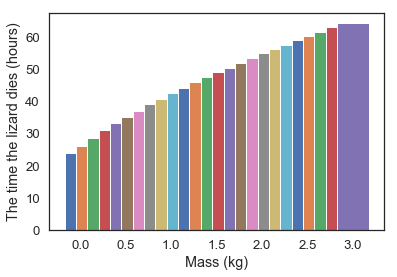

In [10]:
mass = SweepSeries()
width =0.35
for m in linspace(0.0016, 3, 25):
    cold = State(cold=0)
    system = make_system(-10, 10.9, 800, 2500, 0.33, 1250, 561, .048, 1500, 160, .0127, .0762, 100, .2032, m, 3762) 
    mass[m] = run_simulation_1(system, update_func)
    p1 = plt.bar(m, mass[m]*100/3600, width)
plt.xlabel('Mass (kg)')
plt.ylabel('The time the lizard dies (hours)')
plt.show()


This graph proves that as the mass of the lizard increases, the time it takes for the lizard to die also increases. This makes sense because a larger mass generally takes more time to increase temperature. Referring to the Q=MCT equation, the same change in thermal energy will lead to a smaller change in temperature, given a larger mass.

We do acknowledge that the time reported is not completely accurate because in the real world, air would be between the last layer and the lizard, which would drastically decrease the time it would take for the lizard to cool down. But, in the graph we presented, we do accurately show the relationship between mass change and the time it takes for the lizard to die.

## Abstract:

Our question we posed in this project was, which combination of the layers brick, balsa wood, and polyethylene would best insulate a lizard? After running through a few models, we found that the best combination of layers was polyethylene, brick, then balsa wood and brick, polyethylene, then balsa (in order of furthest from the lizard to closest to the lizard). Both of these combinations included the same innermost layer, which also had the lowest thermal conductivity, showing that when layering materials, the best insulating order of layers would have the material with the lowest thermal conductivity on the inside.

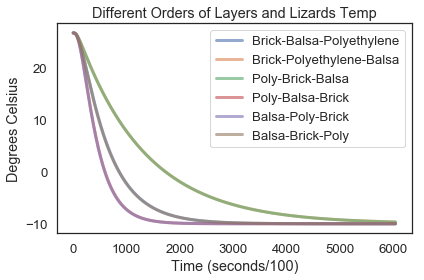
This graph shows how when the material with the lowest thermal conductivity is the closest to the lizard, it insulates the best. We see that with how the green line, representing the layers polyethylene, brick, and balsa wood, has the shallowest slope among the three slopes indicating that the lizard is cooling down slower than the other instances.